In [1]:
#import packages
import numpy as np
from rctorchprivate import *
from numpy import loadtxt
import pylab as pl
from IPython import display
#from RcTorchPrivate import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import time
import matplotlib.gridspec as gridspec
#import latex


#this method will ensure that the notebook can use multiprocessing (train multiple 
#RC's in parallel) on jupyterhub or any other linux based system.
try:
    mp.set_start_method("spawn")
except:
    pass
torch.set_default_tensor_type(torch.FloatTensor)
%matplotlib inline
start_time = time.time()

In [2]:
import scipy
from scipy.integrate import solve_ivp

In [3]:
#integrate.solve_ivp()

In [4]:
import numpy as np
def lotkavolterra(t, z, a, b, c, d):
    x, y = z
    return [a*x - b*x*y, -c*y + d*x*y]

def nl_oscillator(t,z):#t, z, a, b, c, d):
    x, p = z
    return [p, -x-x**3]

#We pass in the parameter values a=1.5, b=1, c=3 and d=1 with the `args`
#argument.
y0 = np.array([0])
y0.shape

(1,)

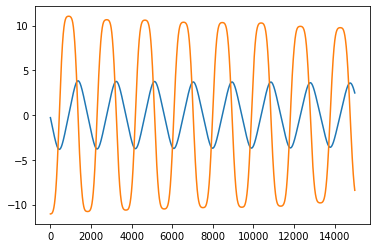

In [5]:
t0, tf = -15, 15
dt = 0.001
t_eval = list(np.arange(0,15, dt))

sol = solve_ivp(nl_oscillator, [t0, tf], [4,0.4], t_eval = t_eval, dense_output=True)#,  [10, 5], args=(1.5, 1, 3, 1),
    
#plt.plot(sol.t, sol.y)
sol.y.shape
plt.plot(sol.y.T)

### Euler

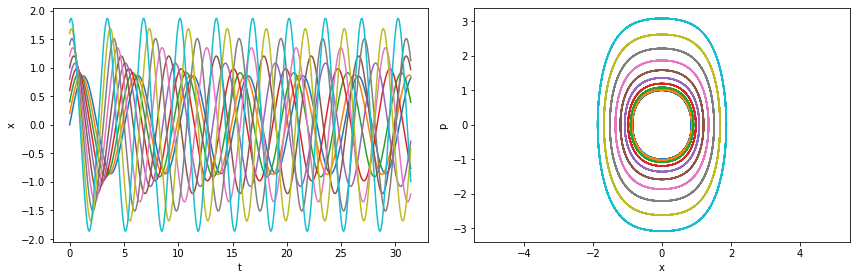

In [6]:

def nlOsc(x0,px0, dt=0.01, lam=1):
    t0, tf = 0, 10*np.pi
    t = np.arange(t0, tf,dt);    
    x_s = np.zeros_like(t); p_s = np.zeros_like(t)
    x_s[0], p_s[0] = x0, px0
 
    for n in range(1,len(t)):
        x_s[n] = x_s[n-1] + dt*p_s[n-1]
        p_s[n] = p_s[n-1] - dt*(x_s[n] + lam*x_s[n]**3)
#     E_euler = energy(x_s, p_s, lam=1)
    
    return t, x_s, p_s 


def energy(x, px, lam=1):    
    Nx=len(x); 
    x=x.reshape(Nx);        px=px.reshape(Nx);    
    #E = 0.5*px**2 + lam*(1 - np.cos(x))
    E = (1/2)*p**2 - 3*x**2 + (21/4)*x**4
    E = E.reshape(Nx)
    return E

fig, ax = plt.subplots(1,2, figsize=[12,4] )
#plt.figure()
p0=1
x0a = np.arange(0 , 2, .2)

for x0 in x0a:
    t,x,p = nlOsc(x0,p0,dt=0.001)
    
    #plt.subplot(1,2,1)
    ax[0].plot(t,x)
    
    ax[0].set_xlabel("t")
    ax[0].set_ylabel("x")

    #plt.subplot(1,2,2)
    ax[1].plot(x,p)
    ax[1].axis('equal')
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("p")

plt.tight_layout()

In [7]:
np.vstack((x,p)).T

array([[ 1.8       ,  1.        ],
       [ 1.801     ,  0.99235727],
       [ 1.80199236,  0.9847039 ],
       ...,
       [-0.98817022, -2.83507726],
       [-0.9910053 , -2.833113  ],
       [-0.99383841, -2.83113753]])

In [8]:
import matplotlib.pyplot as plt
#plt.plot(sol.y.reshape(-1,2))
# !pip install RcTorch==0.7161

In [9]:
lineW = 3
lineBoxW=2

font = {'size'   : 24}

plt.rc('font', **font)

## RC for solving systems of ODEs: an overview

In this notebook we demonstrate that the RC can solve systems of ordinary differential equations. Any higher order ODE can be decomposed into a system of first order ODEs, hence solving systems of ODEs means that RC can solve higher order ODEs. This is a standard procedure followed by integrators. To apply the RC to systems, the RC architecture needs to be modified to return multiple outputs $N_j$, where $j$ indicates a different output. Specifically, the number of the outputs needs to be the same as the number of the equations in a system. Each output has a different set of weights $W_{out}^{(j)}$ while all the $N_j$ share the same hidden states.

We exploit the RC solver in solving the equations of motion for a nonlinear Hamiltonian system, the nonlinear oscillator.  The energy is conserved in this system and thus, we adopt hamiltonian energy regularization that drastically accelerates the training and improves the fidelity of the predicted solutions. 

### Hamiltonian systems
Hamiltonian systems  obey the energy conservation law. In other words, these systems are characterized by a hamiltonian function that represents the total energy of the system which remains constant in time. The hamiltonian of a nonlinear oscillator with unity mass and frequency is given by:
    $$ \mathcal{H}(x,p) = \frac{p^2}{2} + \frac{x^2}{2} + \frac{x^4}{4},$$
and the associated equations of motion reads:
$$    \dot x = p, \\    \dot p = -x - x^3, $$
where $p$ is the momentum and $x$ represents the position of the system. The loss function consists of three parts: $L_\text{ODE}$ for the ODEs of x and p; a hamiltonian penalty $L_{\mathcal{H}}$ that penalizes violations in the energy conservation and is defined by the hamiltonian $\mathcal{H}(x,p)$.
Subsequently, the total $L$  reads:
$$    L = L_\text{ODE}+ L_{\mathcal{H}} + L_\text{reg}\\    = \sum_{n=0}^{K}       \Big[ \left(\dot x_n-p_n\right)^2 + \left(\dot p_n + x_n + x_n^3  \right)^2 +\left(E - \mathcal{H}(x_n, p_n)\right)^2 \Big]   + + L_\text{reg}. $$

In [10]:
def f(u, t ,lam=0,A=0,W=1):
            x,  px = u      # unpack current values of u
            derivs = [px, -x - lam*x**3 +A*np.sin(W*t)]     # you write the derivative here
            return derivs

def convert_ode_coefs(t, ode_coefs):
    """ converts coefficients from the string 't**n' or 't^n' where n is any float
    Parameters
    ----------
    t: torch.tensor
        input time tensor
    ode_coefs: list
        list of associated floats. List items can either be (int/floats) or ('t**n'/'t^n')
    """
    type_t = type(t)
    for i, coef in enumerate(ode_coefs):
        if type(coef) == str:
            if coef[0] == "t" and (coef[1] == "*" or (coef[1] == "*" and coef[2] == "*")):
                pow_ = float(re.sub("[^0-9.-]+", "", coef))
                ode_coefs[i]  = t ** pow_
                print("alterning ode_coefs")
        elif type(coef) in [float, int, type_t]:
            pass
        else:
            assert False, "ode_coefs must be a list floats or strings of the form 't^pow', where pow is a real number."
    return ode_coefs
        
# Scipy Solver   
def NLosc_solution(t, x0,  px0, lam=0, A=0,W=1):
    u0 = [x0, px0]
    # Call the ODE solver
    solPend = odeint(f, u0, t.cpu(), args=(lam,A,W,))
    xP = solPend[:,0];        pxP = solPend[:,1];   
    return xP, pxP

def plot_predictions(RC, results, integrator_model, y0s, ax = None,  
                     int_color = "maroon", RC_color = "aquamarine", RC_linestyle =':'):
    """plots a RC prediction and integrator model prediction for comparison
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    integrator model: function
        the model to be passed to odeint which is a gold standard integrator numerical method
        for solving ODE's written in Fortran. You may find the documentation here:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    X = RC.X.cpu().detach()
    #int_sols = []
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (6,6))
    
    for i, y in enumerate(results["ys"]):
        y = y.cpu().detach()
        if not i:
            labels = ["RC solver","RC solver", "integrator", "integrator"]
        else:
            labels = [None, None, None, None]
        try:
            labels
        except:
            pass
        
        
        #calculate the integrator prediction:
        y_truth, p_truth  = NLosc_solution(RC.X.squeeze().data,y0s[i],1,lam=1, A=0, W= 0) 
        
        #p = y[:,1].cpu()# + v0
        #yy = y[:,0].cpu()# + y0
        
        #plot the integrator prediction
        ax.plot(y_truth, p_truth,  color = int_color , linewidth = lineW+7, 
                label = labels[2])
        
        ax.plot(y[:,0], y[:,1], label = labels[0], 
                linewidth =lineW, color = RC_color, linestyle = RC_linestyle)#"dodgerblue")
#         ax.plot(X, p, color = "red", alpha = 1.0, linewidth =3, 
#                 label = labels[3])
        
    ax.set_xlabel(r'$x(t)$')
    ax.set_ylabel(r'$y(t)$')

    ax.legend();
    #return int_sols

def force(X, A = 0):
    return torch.zeros_like(X)

def plot_rmsr(RC, results, force, ax = None):
    """plots the residuals of a RC prediction directly from the loss function
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    force: function
        the force function describing the force term in the population equation
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (10, 4))
    X = RC.X.cpu().detach()
    ys, ydots = results["ys"], results["ydots"]
    
    residuals = []
    force_t = force(X)
    for i, y in enumerate(ys):
        ydot = ydots[i]
        y = y.cpu().detach()
        ydot = ydot.cpu().detach()
        
        ode_coefs = convert_ode_coefs(t = X, ode_coefs = RC.ode_coefs)
        
        resids = custom_loss(X, y, ydot, None, 
                             force_t = force_t, 
                             ode_coefs = RC.ode_coefs,
                             mean = False,
                             ham = False,
                             init_conds = RC.init_conds)
        if not i:
            resids_tensor = resids
            label = 'Individual Trajectory Residuals'
        else:
            resids_tensor = torch.cat((resids_tensor, resids), axis = 1)
            label = None
        resids_specific_rmsr = torch.sqrt(resids/1) 
            
        ax.plot(X, resids_specific_rmsr, color = "orangered", alpha = 0.4, label = label, linewidth = lineW-1)
        residuals.append(resids)
    
    mean_resid = torch.mean(resids_tensor, axis =1)
    rmsr = torch.sqrt(mean_resid)
    ax.plot(X, rmsr, 
               color = "blue", 
               alpha = 0.9, 
               label = 'RMSR',
               linewidth = lineW-0.5)

    ax.legend(prop={"size":16});
    
    ax.set_xlabel(r'$t$')
    ax.set_yscale("log")
    ax.set_ylabel('RMSR')
    plt.tight_layout()

def driven_force(X, A = 1):
    return A * torch.sin(X)

def no_force(X, A = 0):
    return A

#define a reparameterization function, empirically we find that g= 1-e^(-t) works well)
def reparam(t, order = 1):
    
    exp_t = torch.exp(-t)
    derivatives_of_g = []
    
    g = 1 - exp_t
    g_dot = 1 - g
    return g, g_dot
    
    #first derivative
    
    
    #example code for higher derivatives:
    #####################################
    
    #derivatives_of_g.append(g_dot)
    #derivatives_of_g.append(g)
#     for i in range(order):
#         if i %2 == 0:
#             #print("even")
#             derivatives_of_g.append(g_dot)
#         else:
#             #print("odd")
#             derivatives_of_g.append(-g_dot)
#    return derivatives_of_g


def custom_loss(X, y, ydot, out_weights, force_t = force, 
                reg = False, ode_coefs = None, mean = True,
               enet_strength = None, enet_alpha = None, init_conds = None, lam = 1, ham = True, ham0 = None):
    """ The loss function of the ODE (in this case the population equation loss)
    X: torch.tensor
        The input (in the case of ODEs this is time t)
    y: torch.tensor
        The response variable
    ydot: torch.tensor
        The time derivative of the response variable
    enet_strength: float
        the magnitude of the elastic net regularization parameter. In this case there is no e-net regularization
    enet_alpha: float
        the proportion of the loss that is L2 regularization (ridge). 1-alpha is the L1 proportion (lasso).
    ode_coefs: list
        this list represents the ODE coefficients. They can be numbers or t**n where n is some real number.
    force: function
        this function needs to take the input time tensor and return a new tensor f(t)
    reg: bool
        if applicable (not in the case below) this will toggle the elastic net regularization on and off
    reparam: function
        a reparameterization function which needs to take in the time tensor and return g and gdot, which 
        is the reparameterized time function that satisfies the initial conditions.
    init_conds: list
        the initial conditions of the ODE.
    mean: bool
        if true return the cost (0 dimensional float tensor) else return the residuals (1 dimensional tensor)
    ham : bool
        if true use hamiltonian regularization.
    lam : float
        coefficient affecting the strength of the nonlinearity term.
        
    Returns:
        the residuals or the cost depending on the mean argument (see above)
    """
    
    y, p = y[:,0].view(-1,1), y[:,1].view(-1,1)
    ydot, pdot = ydot[:,0].view(-1,1), ydot[:,1].view(-1,1)
    
    #with paramization
    L =  (ydot - p)**2 + (pdot + y + lam * y**3   - force(X))**2
    
    if mean:
        L = torch.mean(L)
    
    if reg:
        #assert False
        weight_size_sq = torch.mean(torch.square(out_weights))
        weight_size_L1 = torch.mean(torch.abs(out_weights))
        L_reg = enet_strength*(enet_alpha * weight_size_sq + (1- enet_alpha) * weight_size_L1)
        L = L + 0.1 * L_reg 
    if ham:
        y0, p0 = init_conds
        ham = hamiltonian(y, p)
        ham0 = hamiltonian(y0, p0)
        L_H = (( ham - ham0).pow(2)).mean()
        assert L_H >0

        L = L +  0.1 * L_H
    
    #print("L1", hi, "L_elastic", L_reg, "L_H", L_H)
    return L



In [11]:
def optimize_last_layer(esn, 
                        SAVE_AFTER_EPOCHS = 1,
                        epochs = 45000,
                        custom_loss = None,
                        EPOCHS_TO_TERMINATION = None,
                        f = None,
                        lr = 0.05, 
                        reg = None,
                        plott = False,
                        plot_every_n_epochs = 100,
                        force_t = None):#gamma 0.1, spikethreshold 0.07 works
    with torch.enable_grad():
        #define new_x
        new_X = esn.extended_states.detach()
        spikethreshold = esn.spikethreshold

        #force detach states_dot
        esn.states_dot = esn.states_dot.detach().requires_grad_(False)

        #define criterion
        criterion = torch.nn.MSELoss()

        #assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
        #assert not new_X.requires_grad

        #define previous_loss (could be used to do a convergence stop)
        previous_loss = 0

        #define best score so that we can save the best weights
        best_score = 0

        #define the optimizer
        optimizer = optim.Adam(esn.parameters(), lr = lr)

        #optimizer = torch.optim.SGD(model.parameters(), lr=100)
        if esn.gamma_cyclic:
            cyclic_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 10**-6, 0.01,
                                            gamma = esn.gamma_cyclic,#0.9999,
                                            mode = "exp_range", cycle_momentum = False)

        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=esn.gamma)
        lrs = []

        #define the loss history
        loss_history = []

        if plott:
          #use pl for live plotting
          fig, ax = pl.subplots(1,3, figsize = (16,4))

        t = esn.X#.view(*N.shape).detach()
        #force_t = force(t)
        g, g_dot = esn.G
        y0  = esn.init_conds[0]

        flipped = False
        flipped2 = False
        pow_ = -4
        floss_last = 0

        try:
            assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
        except:
            esn.LinOut.weight.requires_grad_(True)
            esn.LinOut.bias.requires_grad_(True)

        y0, p0 = esn.init_conds
        
        assert False, y0 + p0

        #         ham0 = (1/2)*(y0**2 + p0**2) + lam*y0**4/4
        #         assert False, ham0

        #begin optimization loop
        for e in range(epochs):

            optimizer.zero_grad()

            N = esn.forward( esn.extended_states )
            N_dot = esn.calc_Ndot(esn.states_dot)

            y = g *N 

            ydot = g_dot * N + g * N_dot
            
            for i in range(y.shape[1]):
                
                y[:,i] = y[:,i] + esn.init_conds[i]
                
            #y[:,1] = y[:,1] + esn.init_conds[1]

            #assert N.shape == N_dot.shape, f'{N.shape} != {N_dot.shape}'

            #assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad

            #total_ws = esn.LinOut.weight.shape[0] + 1
            #weight_size_sq = torch.mean(torch.square(esn.LinOut.weight))
            

            loss = custom_loss(esn.X, y, ydot, esn.LinOut.weight, reg = reg, ode_coefs = esn.ode_coefs, init_conds = esn.init_conds, 
                    enet_alpha= esn.enet_alpha, enet_strength = esn.enet_strength, force_t = force_t, ham0 = ham0)
            loss.backward()
            optimizer.step()
            if esn.gamma_cyclic and e > 100 and e <5000:
                cyclic_scheduler.step()
                lrs.append(optimizer.param_groups[0]["lr"])

            loss_history.append(loss)

            # if e == 10**3:
            #     if floss > 10**(5):
            #         EPOCHS_TO_TERMINATION = e + 50

            # if e == 10**4:
            #     if floss > 10**(2.5):
            #         EPOCHS_TO_TERMINATION = e + 50
                    
            if e > 0:
                loss_delta = float(torch.log(floss_last) - torch.log(loss)) 
                if loss_delta > esn.spikethreshold:# or loss_delta < -3:
                    lrs.append(optimizer.param_groups[0]["lr"])
                    scheduler.step()


            # if not e and not best_score:
            #     best_bias, best_weight, best_fit = esn.LinOut.bias.detach(), esn.LinOut.weight.detach(), y.clone()

            if e > SAVE_AFTER_EPOCHS:
                if not best_score:
                    best_score = min(loss_history)
                if loss < best_score:  
                    best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
                    best_score = loss
                    best_fit = y.clone()
                    best_ydot = ydot.clone()
            floss_last = loss
            # else:
            #     if floss < best_score:
            #         best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
            #         best_score = float(loss)
            #         best_fit = y.clone()
            #         best_ydot = ydot.clone()
            
            # if e >= EPOCHS_TO_TERMINATION and EPOCHS_TO_TERMINATION:
            #     return {"weights": best_weight, "bias" : best_bias, "y" : best_fit, 
            #           "loss" : {"loss_history" : loss_history},  "best_score" : torch.tensor(best_score),
            #           "RC" : esn}
            
            # if plott and e:

            #     if e % plot_every_n_epochs == 0:
            #         for param_group in optimizer.param_groups:
            #             print('lr', param_group['lr'])
            #         ax[0].clear()
            #         logloss_str = 'Log(L) ' + '%.2E' % Decimal((loss).item())
            #         delta_loss  = ' delta Log(L) ' + '%.2E' % Decimal((loss-previous_loss).item())

            #         print(logloss_str + ", " + delta_loss)
            #         ax[0].plot(y.detach().cpu())
            #         ax[0].set_title(f"Epoch {e}" + ", " + logloss_str)
            #         ax[0].set_xlabel("t")

            #         ax[1].set_title(delta_loss)
            #         ax[1].plot(ydot.detach().cpu(), label = "ydot")
            #         #ax[0].plot(y_dot.detach(), label = "dy_dx")
            #         ax[2].clear()
            #         #weight_size = str(weight_size_sq.detach().item())
            #         #ax[2].set_title("loss history \n and "+ weight_size)

            #         ax[2].loglog(loss_history)
            #         ax[2].set_xlabel("t")

            #         #[ax[i].legend() for i in range(3)]
            #         previous_loss = loss.item()

            #         #clear the plot outputt and then re-plot
            #         display.clear_output(wait=True) 
            #         display.display(pl.gcf())


        return {"weights": best_weight, "bias" : best_bias, "y" : best_fit, "ydot" : best_ydot, 
              "loss" : {"loss_history" : loss_history}, "best_score" : best_score,
              "RC" : esn}

In [12]:
def force(X, A = 0):
    """ #TODO descripton
    Parameters
    ----------
    """
    return torch.zeros_like(X)
lam =1
def hamiltonian(x, p, lam = lam):
    """ #TODO descripton
    Parameters
    ----------
    """
    return (1/2)*(x**2 + p**2) + lam*x**4/4

In [13]:
BURN_IN = 1000
x0,xf, nsteps = 0, 5, 1000
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False)

#the length of xtrain won't matter above. Only dt , x0, and xf matter for ODEs.
#the reason for this is that the input time vector is reconstructed internally in rctorch
#in order to satisfy the specified dt.
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False).view(-1,1)

x0,xf, nsteps = 5, 10, 1000
xtest = torch.linspace(x0, xf, steps = nsteps, requires_grad=False).view(-1,1)

In [14]:
# nl_oscillator_hp_set = {'dt': 0.001,
#  'regularization': 48.97788193684461,
#  'n_nodes': 100,
#  'connectivity': 0.017714821964432213,
#  'spectral_radius': 2.3660330772399902,
#  'leaking_rate': 0.0024312976747751236,
#  'bias': 0.37677669525146484,
#  'enet_alpha': 0.2082211971282959,
#  'enet_strength': 0.118459548397668,
#  'spikethreshold': 0.43705281615257263,
#   #                      'spikethreshold' : 1000,
#  'gamma': 0.09469877928495407,
#  'gamma_cyclic': 0.999860422666841}

# nl_oscillator_hp_set = {'dt': 0.01,
#  'connectivity': 0.2646055554275079,
#  'spectral_radius': 2.634786605834961,
#  'n_nodes': int(202.95497131347656),
#  'leaking_rate': 0.034423843026161194,
#  'bias': 0.30512213706970215,
#  'spikethreshold': 0.2884502708911896,
#  'input_scaling': 1.9447743892669678,
#  'gamma': 0.18051370978355408,
#  'gamma_cyclic': 0.9997521885755591}
#trained to 20*pi
nl_oscillator_hp_set = {'dt': 0.001,
       'n_nodes': 500,
       'connectivity': 0.019946997092875757,
       'spectral_radius': 2.4289157390594482,
       'regularization': 49.04219249279563,
       'leaking_rate': 0.0032216429244726896,
       'bias': 0.3808490037918091,
       'enet_alpha': 0.2040003091096878,
       'enet_strength': 0.07488961475845243,
       'spikethreshold': 0.4231834411621094,
       'gamma': .09350859373807907,
       'gamma_cyclic' : 0.9999,
        'input_scaling' : 0.0}

In [15]:
base = 10*np.pi#10*np.pi
x0, xf= 0, base
nsteps = int(abs(xf - x0)/(nl_oscillator_hp_set["dt"]))
xtrain = torch.linspace(x0, xf, nsteps, requires_grad=False).view(-1,1)
float(xtrain[1]- xtrain[0])

0.0010000612819567323

In [16]:
%%time
y0s = np.arange(0.7, 1.8, 0.2)
v0 = 0.3

RC = EchoStateNetwork(**nl_oscillator_hp_set, 
                       random_state = 209, 
                       feedback = True, 
                       id_ = 10,
                       activation_function = "sin",
                       output_activation = "identity",
                       dtype = torch.float32, n_inputs = 1, n_outputs = 2)

train_args = {"burn_in" : int(BURN_IN), 
              "ODE_order" : 1,
              "force" : force,
              "reparam_f" : reparam,
              "init_conditions" : [y0s, float(v0)],
              "ode_coefs" :       [1, 1],
              "X" :   xtrain.view(-1, 1),
              "eq_system" : True,
              
              #"out_weights" : out_weights
              }
#fit
results = RC.fit(**train_args, 
                 SOLVE = True,
                 train_score = True,
                 backprop_f = optimize_last_layer, 
                 epochs = 100,#00,
                 ODE_criterion = custom_loss,
                 n_outputs = 2)
# score, pred =  RC.test(X = v_test[:-1],
#                                y = y_test[1:])

2021-09-06 12:34:45,556	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8266


UnboundLocalError: local variable 'last_outputs' referenced before assignment

In [17]:
for y in results['ys']:
    print(y)
    plt.plot(y.detach())

NameError: name 'results' is not defined

In [ ]:
hi = RC.lastoutput

In [ ]:
RC.lastoutput

In [ ]:
results = []
for lastoutput in hi:
    print(lastoutput)
    RC.lastoutput = lastoutput
    result = RC.test(X = xtest, y = None)
    results.append(result)

In [ ]:
for result in results[0][1]:
    
    plt.plot(result)

In [ ]:
for output in RC.last_output:
    

In [ ]:
RC.init_conds

In [ ]:
RC.LinIn.weight.shape

In [ ]:
font = {'size'   : 14}
plt.rc('font', **font)
fig = plt.figure(figsize = (7,9)); gs1 = gridspec.GridSpec(3, 3);
ax = plt.subplot(gs1[:-1, :])

plot_predictions(RC, results, NLosc_solution, y0s, ax = ax, int_color = "black", RC_color = "cyan")

ax = plt.subplot(gs1[-1, :])
# plot_data = plot_rmsr(pop_RC, 
#                           results, 
#                           force = no_force, 
#                           ax = ax)

plot_data = plot_rmsr(RC,
                      results, 
                      force = no_force, 
                      ax = ax)

In [ ]:
def plot_comparison(RC, results, force, integrator_model, y0s, v0, ax = None, euler_f = nlOsc):
    
    X = process(RC.X)
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (6,6))
    
    rc_residuals = []
    eu_residuals = []
    t=np.array(X.cpu().squeeze())
    for i, y in enumerate(results["ys"]):
        y = process(y)
        y = y.view(-1,2)
        if not i:
            labels = ["RC", "Integrator Solution"]
        else:
            labels = [None, None]
        

        #calculate the integrator prediction:
        
        
        int_sol = solve_ivp(nl_oscillator, [min(t), max(t)], [y0s[i],v0], t_eval = t,
                            dense_output=True)
        int_sol = int_sol.y.T
        #int_sol = odeint(integrator_model, y0s[i], np.array(X.cpu().squeeze()))
        int_sol = torch.tensor(int_sol).view(-1,2)

        t, xs, ps = euler_f(y0s[i], v0,dt=RC.dt)
        euler_sol = torch.tensor(np.vstack((xs,ps)).T)
        
        try:
            rc_resids = (int_sol - y).pow(2)
            eu_resids = (euler_sol - int_sol).pow(2)
        except:
            rc_resids = (int_sol[:len(y)-1] - y[:len(y)-1]).pow(2)
            eu_resids = (euler_sol[:len(y)-1] - int_sol[:len(y)-1]).pow(2)
        if not i:
            rc_resids_tensor = rc_resids
            eu_resids_tensor = eu_resids
            labels = ["rc", "euler"]
        else:
            rc_resids_tensor = torch.cat((rc_resids_tensor, rc_resids), axis = 1)
            eu_resids_tensor = torch.cat((eu_resids_tensor, eu_resids), axis = 1)
            #breakpoint()
            labels = [None, None]
        
        rc_specific_rmsr = torch.sqrt(rc_resids/1) 
        eu_specific_rmsr = torch.sqrt(eu_resids/1) 
        try:
            
            ax.plot(X[:-1], rc_specific_rmsr,  color = "blue", alpha = 0.7, linewidth = lineW -1,linestyle = '--',  label = labels[0])
            ax.plot(X[:-1], eu_specific_rmsr, color = "darkorange", alpha = 0.7, linewidth = lineW -1, linestyle = '--', label = labels[1])
        except:
            ax.plot(X, rc_specific_rmsr,  color = "blue", alpha = 0.7, linewidth = lineW -1,linestyle = '--',  label = labels[0])
            ax.plot(X, eu_specific_rmsr, color = "darkorange", alpha = 0.7, linewidth = lineW -1, linestyle = '--', label = labels[1])
        
        
        rc_residuals.append(rc_resids)
        eu_residuals.append(eu_resids)
        
        #np.vstack((x,p)).T
    
    rc_mean_resid = torch.mean(rc_resids_tensor, axis =1)
    rc_rmsr = torch.sqrt(rc_mean_resid)
    
    eu_mean_resid = torch.mean(eu_resids_tensor, axis =1)
    eu_rmsr = torch.sqrt(eu_mean_resid)
    #breakpoint()
    print(f'rc_rmsr {rc_rmsr }')
    plt.plot(X[:len(rc_rmsr)], rc_rmsr, color = "blue", label = "rc mean rmsr")
    print(f'eu_rmsr {eu_rmsr }')
    plt.plot(X[:len(rc_rmsr)], eu_rmsr, color = "darkorange", label = "euler mean rmsr")

        #plt.xlabel("t")
        #plt.ylabel("y")
        
        #ax.plot(X, y, label = labels[0], linewidth = lineW + 2, alpha = 0.9)
        
        #plot the integrator prediction
        #ax.plot(X, int_sol, '--', color = "black", alpha = 0.95, label = labels[1],  linewidth = lineW - 1)
    ax.set_xlabel(r'$t$')
    ax.set_yscale("log")
    ax.set_ylabel(r'{RMSR}')
    plt.legend()


In [ ]:
def process(tensor_):
    """ takes a tensor and prepares it for plotting.
    """
    return tensor_.cpu().detach()
        
plot_comparison(RC, results, force, nlOsc, y0s, v0)

In [ ]:
end_time = time.time()
print(f'Total notebook runtime: {end_time - start_time:.2f} seconds')